# Setting up

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets, tree
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.random import set_seed

# Import data
from preprocessing import load_diabetes_prepr

# Interpretability measures
from interpretability import PDP

In [ ]:
def find_best_model(model, parameters, X_train, y_train): 
    clf = GridSearchCV(model, parameters, scoring=('neg_root_mean_squared_error'), cv=KFold())
    clf.fit(X_train, y_train)

    return clf

def print_errors(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    
    if model_name == "Neural network":
        y_pred = np.reshape(y_pred, len(y_test))
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print("RMSE ({}): {}".format(model_name, rmse))
    r2 = r2_score(y_test, y_pred)
    print("R-squared score ({}) : {}".format(model_name, r2))

In [ ]:
X, y, feature_names = load_diabetes_prepr()
seed = 3012

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Decision tree regressor

## Training model

In [ ]:
model_name = "decision tree regressor"
parameters = {'criterion': ('squared_error', 'friedman_mse', 'absolute_error', 'poisson'), 'splitter': ('best', 'random') , 'min_samples_split': np.arange(2, 301)}
tr = tree.DecisionTreeRegressor(random_state=seed)

clf = find_best_model(tr, parameters, X_train, y_train)
print_errors(clf, model_name, X_test, y_test)

model = clf.best_estimator_
model

RMSE (decision tree regressor): 66.50845607349149
R-squared score (decision tree regressor) : 0.4192673441013629


DecisionTreeRegressor(min_samples_split=71, random_state=3012)

## Intrinsic interpretability

<AxesSubplot:>

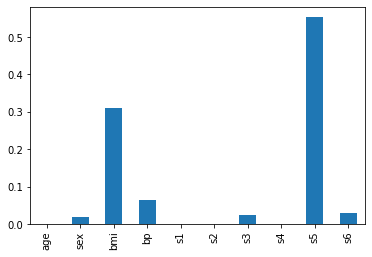

In [ ]:
df = pd.Series(data=model.feature_importances_, index=feature_names)
df.plot.bar()

## Partial dependence plot

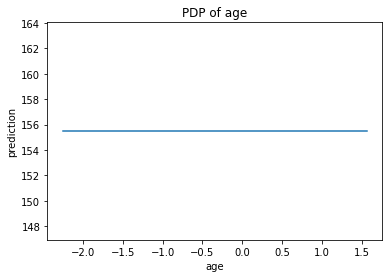

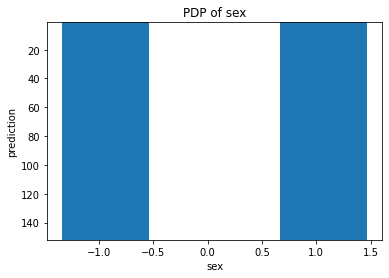

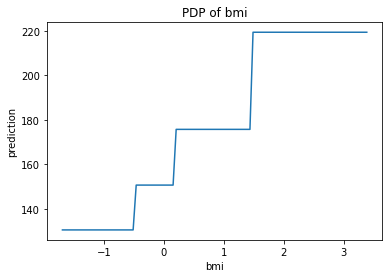

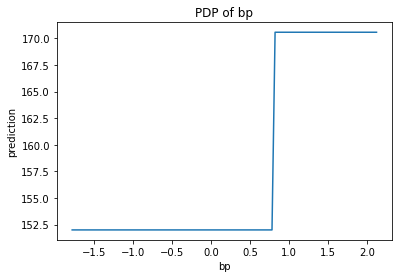

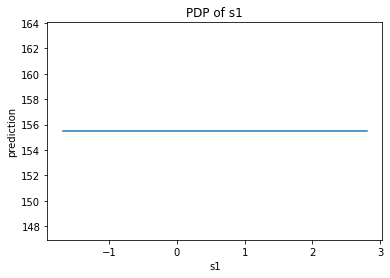

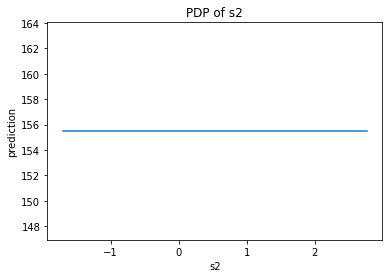

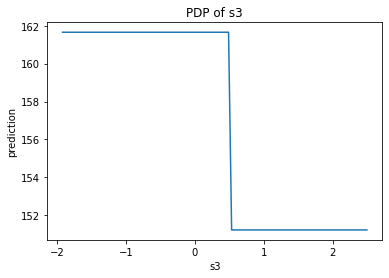

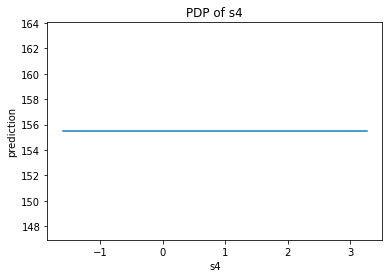

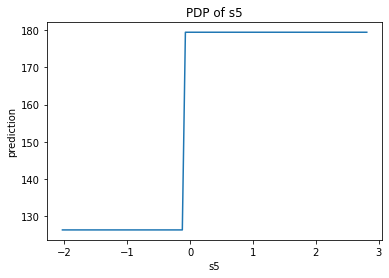

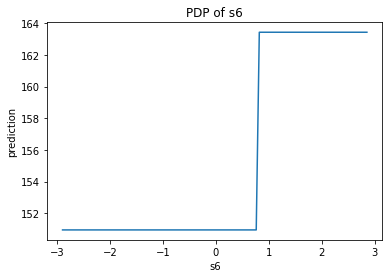

In [ ]:
categorical = [False for _ in range(11)]
categorical[1] = True

for i in range(X_test.shape[1]):
    PDP(i, feature_names[i], model, X_test, y_test, categorical=categorical[i])
    plt.show()
    plt.close()

# Linear regression models

## Training model

In [ ]:
model_name = "linear regression"
parameters = {}
linreg = LinearRegression()

clf = find_best_model(linreg, parameters, X_train, y_train)
print_errors(clf, model_name, X_test, y_test)

model = clf.best_estimator_
model

RMSE (linear regression): 58.94293390689424
R-squared score (linear regression) : 0.543872754881746


LinearRegression()

Also tried Lasso and Ridge regression, but their errors were consistently larger

## Intrinsic interpretability

<AxesSubplot:>

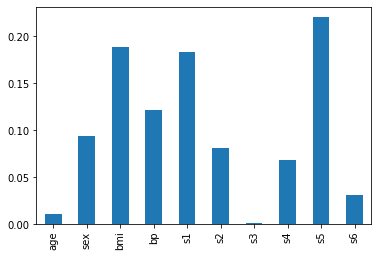

In [ ]:
df = pd.Series(data=np.abs(model.coef_)/np.sum(np.abs(model.coef_)), index=feature_names)
df.plot.bar()

## Partial dependence plot

In [ ]:
categorical = [False for _ in range(11)]
categorical[1] = True

for i in range(X_test.shape[1]):
    PDP(i, feature_names[i], model, X_test, y_test, categorical=categorical[i])
    plt.show()
    plt.close()

# KNN regressor

## Training model

In [ ]:
model_name = "k-nearest neighbors"
parameters = {'n_neighbors': np.arange(1, 280), 'weights': ('uniform', 'distance')}
kNN = KNeighborsRegressor()

clf = find_best_model(kNN, parameters, X_train, y_train)
print_errors(clf, model_name, X_test, y_test)

model = clf.best_estimator_
model

RMSE (k-nearest neighbors): 64.45688846172169
R-squared score (k-nearest neighbors) : 0.4545421586812478


KNeighborsRegressor(n_neighbors=18, weights='distance')

## Partial dependence plot

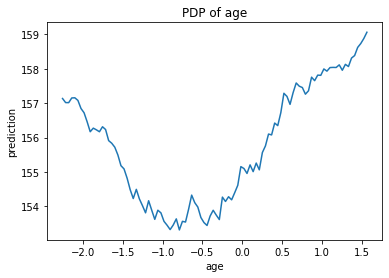

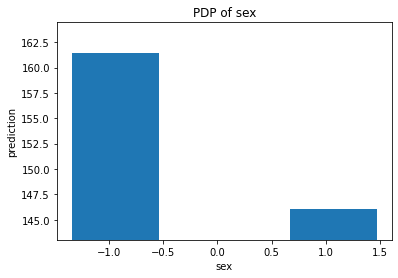

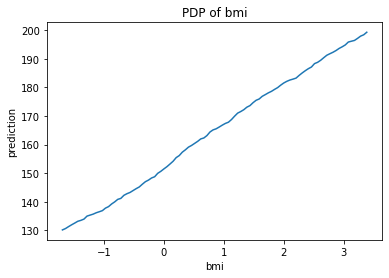

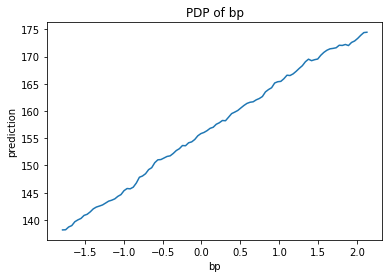

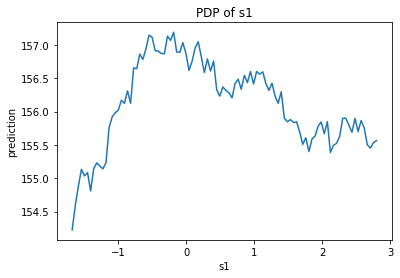

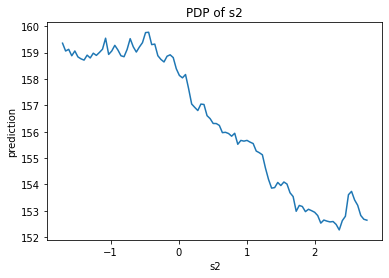

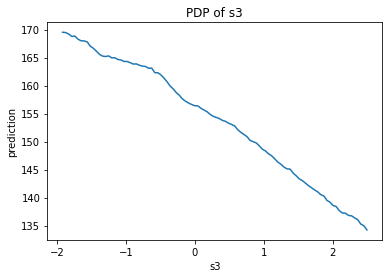

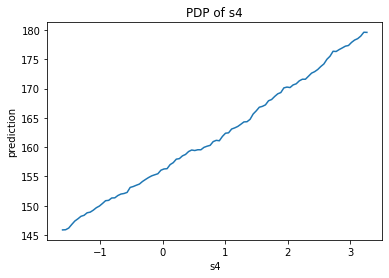

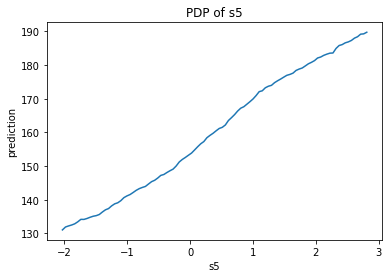

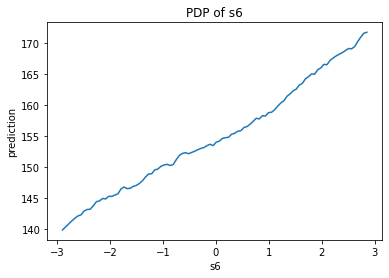

In [ ]:
categorical = [False for _ in range(11)]
categorical[1] = True

for i in range(X_test.shape[1]):
    PDP(i, feature_names[i], model, X_test, y_test, categorical=categorical[i])
    plt.show()
    plt.close()

# Neural network

In [ ]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=seed)

In [ ]:
# Initialise neural network
BATCH_SIZE=64
INPUT_SIZE= X_train.shape[1]

set_seed(seed)

model = Sequential()
model.add(Input(INPUT_SIZE))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.1))
# model.add(Dense(10, activation="relu"))
# model.add(Dropout(0.1))
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam',
                loss="mean_absolute_error",
                metrics=['mean_squared_error'])

n_epochs = 300
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=n_epochs, validation_data=(X_val, y_val)) # validation_split=0.2)

Epoch 1/300
5/5 [==============================] - 3s 530ms/step - loss: 146.4270 - mean_squared_error: 27086.4674 - val_loss: 140.8831 - val_mean_squared_error: 25423.3105
Epoch 2/300
5/5 [==============================] - 0s 24ms/step - loss: 147.9914 - mean_squared_error: 27120.5641 - val_loss: 140.7796 - val_mean_squared_error: 25395.7246
Epoch 3/300
5/5 [==============================] - 0s 21ms/step - loss: 146.4534 - mean_squared_error: 26560.8151 - val_loss: 140.6728 - val_mean_squared_error: 25367.3555
Epoch 4/300
5/5 [==============================] - 0s 19ms/step - loss: 152.5552 - mean_squared_error: 28749.9326 - val_loss: 140.5561 - val_mean_squared_error: 25335.6348
Epoch 5/300
5/5 [==============================] - 0s 17ms/step - loss: 148.6716 - mean_squared_error: 27654.7334 - val_loss: 140.4284 - val_mean_squared_error: 25301.2031
Epoch 6/300
5/5 [==============================] - 0s 21ms/step - loss: 146.2454 - mean_squared_error: 26251.7858 - val_loss: 140.2891 - va

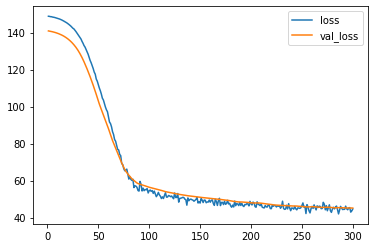

299
(array([299]),)


In [ ]:
for key in ['loss', 'val_loss']:
    plt.plot(np.arange(1, n_epochs+1), history.history[key], label=key)
plt.legend()
plt.show()

print(np.argmin(history.history['val_loss']))
print(np.where(history.history['val_loss'] == np.min(history.history['val_loss'])))

In [ ]:
model_name = "Neural network"
print_errors(model, model_name, X_test, y_test)

RMSE (Neural network): 63.249175795575304
R-squared score (Neural network) : 0.47479088252157353


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5161fece-8ef6-4825-9ea6-16ebba884483' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>